In [1]:
import sys
sys.path.append("../")

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

In [3]:
from MultilabelKernelPerceptron import MultilabelKernelPerceptron
from KMeans import DATASET_LOCATION, DEVICE
from MNIST import mnist_loader, label_set
from utils import polynomial, sgn_label, sgn, SEED

_ = torch.manual_seed(SEED)

## Load the data

In [4]:
training_batch_size = 60_000
test_batch_size = 10_000

(x_train, y_train), (x_test, y_test) = mnist_loader(training_batch_size, test_batch_size)

## Sample

In [5]:
num = 30
examples = x_train[:num]
labels = y_train[:num]

rows = 5
cols = 6

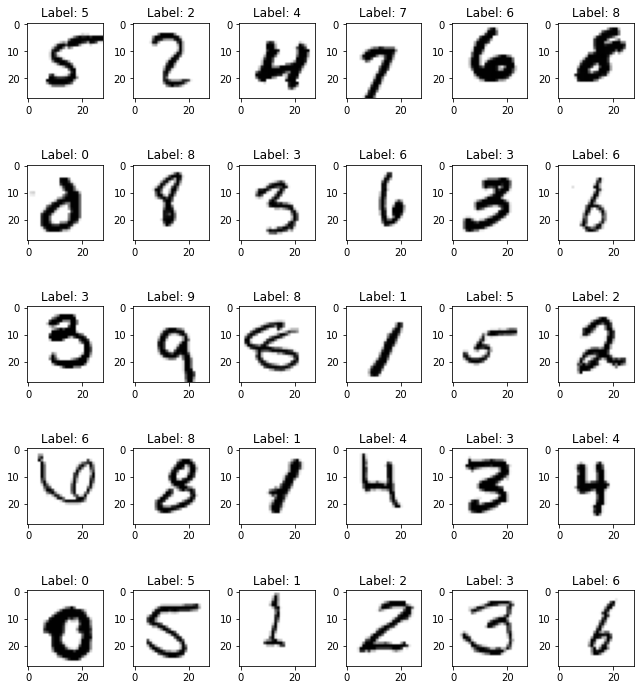

In [6]:
fig, axes = plt.subplots(rows, cols, figsize=(1.5 * cols, 2 * rows))

for i in range(num):
    ax = axes[i // cols, i % cols]
    image = examples[i].reshape((1, 28, 28))
    ax.imshow(image[0], cmap='gray_r')
    ax.set_title(f"Label: {labels[i]}")
    
plt.tight_layout()
plt.show()

## Run the algorithm with the 1500 reduction

In [7]:
x_train_km = torch.load(f"../{DATASET_LOCATION}/1500/x_train_km.pt")
y_train_km = torch.load(f"../{DATASET_LOCATION}/1500/y_train_km.pt")

mkp = MultilabelKernelPerceptron(partial(polynomial, degree=5), label_set, 5, x_train_km, y_train_km, DEVICE)

In [8]:
%%time
mkp.fit()

CPU times: user 8.55 s, sys: 343 ms, total: 8.89 s
Wall time: 3.47 s


In [9]:
def classify(model, examples):
    kernel_matrix = polynomial(examples, x_train_km.T)
    scores = torch.zeros((model.shape[0], examples.shape[0]))

    for label, alpha in enumerate(model):
        scores[label] = torch.sum(kernel_matrix * sgn_label(y_train_km, label) * alpha, 1)

    return torch.argmax(scores, 0)

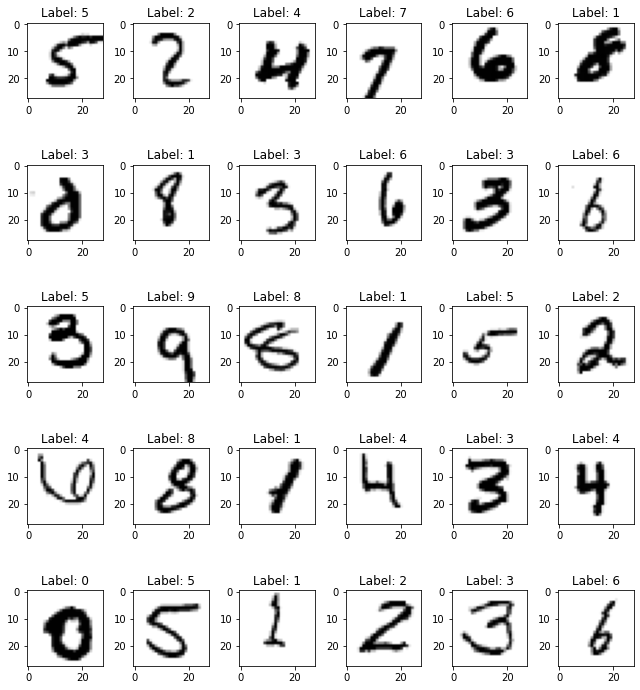

In [10]:
fig, axes = plt.subplots(rows, cols, figsize=(1.5 * cols, 2 * rows))
predictions = classify(mkp.model, examples)

for i in range(num):    
    ax = axes[i // cols, i % cols]
    image = examples[i].reshape((1, 28, 28))
    ax.imshow(image[0], cmap='gray_r')
    ax.set_title(f"Label: {predictions[i]}")
    
plt.tight_layout()
plt.show()

### K-means digits
To speed up computations the dataset has been reduced using k-means, we can visualize the obained digits.

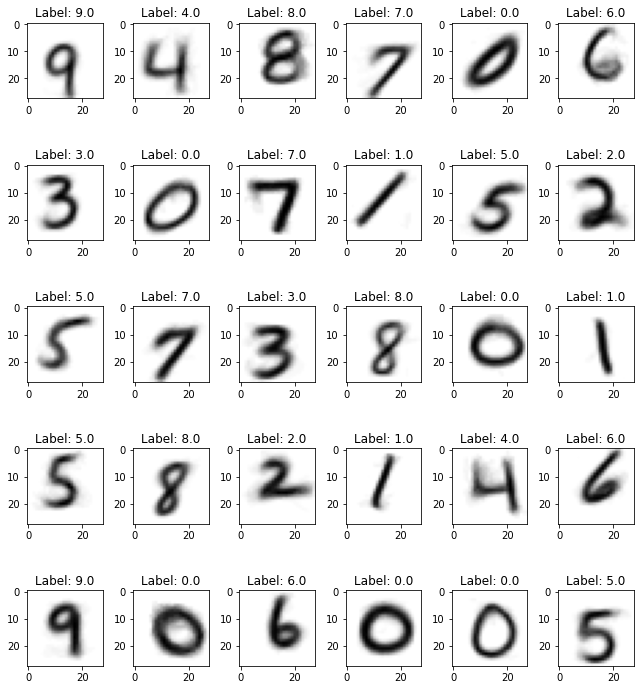

In [11]:
fig, axes = plt.subplots(rows, cols, figsize=(1.5 * cols, 2 * rows))

for i in range(num):    
    ax = axes[i // cols, i % cols]
    image = x_train_km[i].reshape((1, 28, 28))
    ax.imshow(image[0], cmap='gray_r')
    ax.set_title(f"Label: {int(y_train_km[i])}")
    
plt.tight_layout()
plt.show()